# Airbnb Seattle Dataset Analysis

In [193]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline
pd.set_option("max_columns", None)
sns.set_palette(sns.color_palette("colorblind"))

## Business understanding

A friend of mine coming from the Seattle area told me about the rapidly climbing prices for real estate since the establishment of Amazon and other tech giants like Microsoft. So I was curious to examine the Airbnb dataset for Seattle and have a closer look at how satisfied short term renters are in relation to the going rates. I want to understand:
- How and why do prices change over a year?
- How is the neighborhood of a listing related to its rate?
- Is the overall customer satisfaction related to the listing price?

In [76]:
# read in data
listings = pd.read_csv('seattle/listings.csv')
calendar = pd.read_csv('seattle/calendar.csv')

### Common functions

In [3]:
def convert_to_bool(string):
        """
        INPUT: 
        string - string to convert to bool

        converts string into boolean value
        "f" = False
        "t" = True
        """
        try:
            return False if string == "f" else True
        except:
            pass
        
def clean_price(price):
        """
        INPUT: price - string with price information
        OUTPUT: float_price - price as float value

        The function removes the characters ',' & '$' from the string
        and converts it into an integer value.
        """
            
        try:
            return int(price[1:-3].replace(",", ""))
            
        except:
            pass
        
def clean_rate(rate):
        """
        INPUT: rate - string with percentage
        OUTPUT: float_ratio - rate as float value

        The function removes the characters '%'
        and converts it into an float value.
        """
            
        try:
            return int(rate.replace("%", ""))
        except:
            pass

## How do prices of listings change over time?

In [4]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


To answer this question we'll first have to clean up our data. We will convert the date to datetime format and extract year, month, day and day of the week from the object. Also we'll convert the column availability into boolean values and transform the price column to integer values. 

In [5]:
def clean_calendar_df(df):
    '''
    INPUT
    df - pandas dataframe containing the data from calendar.csv
    
    OUTPUT
    df - cleanup up dataframe
    
    This function cleans df using the following steps:
    1. convert 'date' string in datetime value
    2. adds columns  for ywar, month, day and day of the week to dataframe
    3. convert 'available' string in bool value
    4. convert 'currency' string in float value
    '''
        
    df.date = pd.to_datetime(df.date)
    df['year'] = df.date.map(lambda date: date.year)
    df['month'] = df.date.map(lambda date: date.month)
    df['day'] = df.date.map(lambda date: date.day)
    df['weekday'] = df.date.map(lambda date: date.dayofweek)
    df.available = df.available.map(lambda string: convert_to_bool(string))
    df.price = df.price.map(lambda price: clean_price(price))
    
    return df

clean_calendar = clean_calendar_df(calendar)

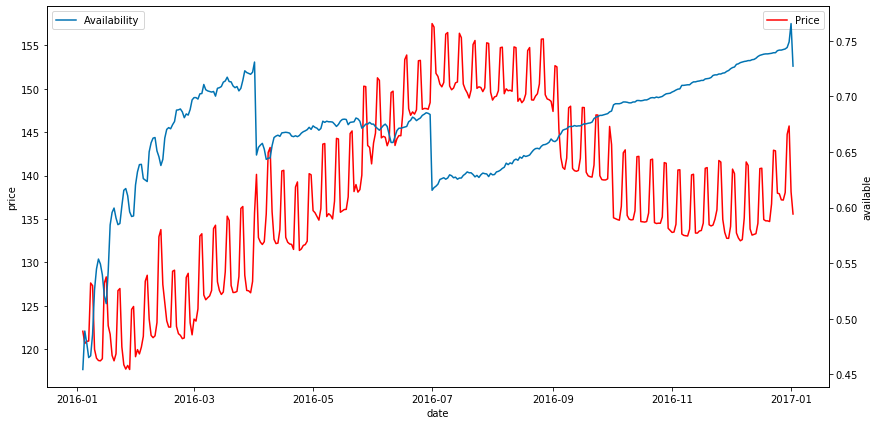

In [6]:
data = clean_calendar.groupby('date')[['price', 'available']].mean().reset_index()

# plot availability ratio and average prices
f, ax = plt.subplots(figsize=(14,7))
sns.lineplot(x = 'date' ,y = 'price', 
                  data = data, color="r", label='Price')

sns.lineplot(x = 'date', y = 'available',
             data=data, ax=ax.twinx(), linestyle=':', label='Availability');

Clearly, the average prices for these listings peaks during the summer months. Though, the price doesn't seem to correlate with the average availability for these listings. There are two drops in availability that, according to Airbnb data, occur in other cities during that time. The drops in availability don't connect to certain holidays. These drops may be due to an Airbnb internal algorithm.
Another takeaway from the upper graph is the periodical short term variations in listing prices. These are likely price changes over the week based on demand. So let's have closer look at that.

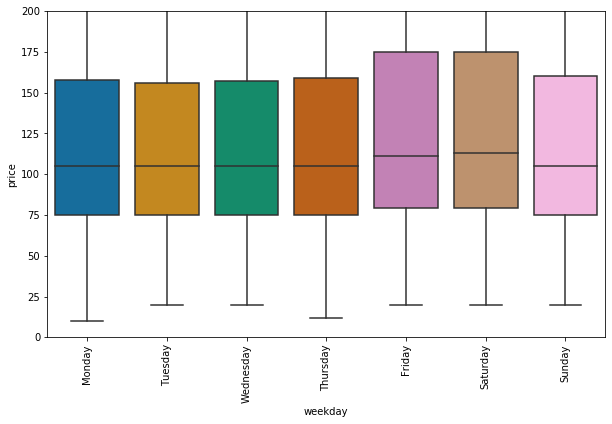

In [7]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

# # plot prices per weekday
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x = 'weekday' ,y = 'price',  data= clean_calendar)

ax.set_ylim((0,200))
ax.set_xticklabels(clean_calendar.weekday.map(dayOfWeek).unique(), rotation=90);

Average prices on a Friday and Saturday are higher than for the rest of the week. This makes perfect sense considering people will usually start their weekend trip on a Friday and end it on Sunday.

## Listings

In [77]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

This dataframe offers a lot of information that we will not need for our further analysis. So first we get rid of columns we don't use and then go on to clean up the leftover data.

In [78]:
# drop columns that aren't relevant for the analysis
cols_to_drop = []
text_cols = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 
             'host_name', 'host_location', 'host_about', 'host_neighbourhood', 'host_verifications']
url_cols = list(listings.columns[listings.columns.str.endswith('url')])
geo_cols = ['neighbourhood', 'neighbourhood_group_cleansed', 'city', 'street', 'state', 'zipcode', 
            'market', 'smart_location', 'country_code', 'country', 'is_location_exact']
missing_data_cols = ['license', 'square_feet', 'monthly_price', 'weekly_price']
irrelevant_cols = ['scrape_id', 'last_scraped', 'jurisdiction_names', 'host_listings_count', 'calculated_host_listings_count']

cols_to_drop = list(set().union(text_cols, url_cols, geo_cols, missing_data_cols, irrelevant_cols))
listings_df = listings.drop(cols_to_drop, axis=1)

In [79]:
# clean up columns with prices and fill missing price information
price_columns = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']

for col in price_columns:
    listings_df[col] = listings_df[col].map(lambda price: clean_price(price))

In [80]:
# transform percentage strings in float values
percent_columns = ['host_response_rate', 'host_acceptance_rate']

for col in percent_columns:
    listings_df[col] = listings_df[col].map(lambda rate: clean_rate(rate))

In [81]:
# clean up columns with prices
bool_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
                'has_availability', 'requires_license', 'instant_bookable', 
                'require_guest_profile_picture', 'require_guest_phone_verification']

for col in bool_columns:
    listings_df[col] = listings_df[col].map(lambda string: convert_to_bool(string))

In [82]:
listings_df.select_dtypes(['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           3818 non-null   int64  
 1   host_id                      3818 non-null   int64  
 2   host_response_rate           3295 non-null   float64
 3   host_acceptance_rate         3045 non-null   float64
 4   host_total_listings_count    3816 non-null   float64
 5   latitude                     3818 non-null   float64
 6   longitude                    3818 non-null   float64
 7   accommodates                 3818 non-null   int64  
 8   bathrooms                    3802 non-null   float64
 9   bedrooms                     3812 non-null   float64
 10  beds                         3817 non-null   float64
 11  price                        3818 non-null   int64  
 12  security_deposit             1866 non-null   float64
 13  cleaning_fee      

## Missing values

Now let's adress the missing values in our dataset. First let's get an overview where our mising values are located to decide what to do with them.

In [83]:
def get_missing_values_ratio(df, axis=0, ascending=False):
    """Get missing values in columns of df."""
    
    missing_values_df = df.isna().mean(axis=axis).sort_values(ascending=ascending)
    return missing_values_df[missing_values_df > 0]

In [84]:
missing_values_df = get_missing_values_ratio(listings_df)
missing_values_df

security_deposit               0.511262
cleaning_fee                   0.269775
host_acceptance_rate           0.202462
review_scores_checkin          0.172342
review_scores_accuracy         0.172342
review_scores_value            0.171818
review_scores_location         0.171556
review_scores_cleanliness      0.171032
review_scores_communication    0.170508
review_scores_rating           0.169460
reviews_per_month              0.164222
last_review                    0.164222
first_review                   0.164222
host_response_rate             0.136983
host_response_time             0.136983
bathrooms                      0.004191
bedrooms                       0.001572
host_total_listings_count      0.000524
host_since                     0.000524
beds                           0.000262
property_type                  0.000262
dtype: float64

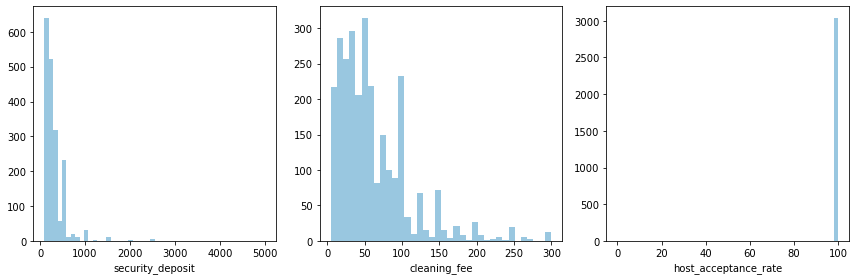

In [85]:
# top 3 quantitative variables with missing values
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for (i, col) in enumerate(missing_values_df.index[:3]):
    sns.distplot(listings_df[col].dropna(), ax=axs[i], kde=False)
fig.tight_layout()

So here we see the 3 colums with the most missing values. We'll fill these mising values with with '0' for the security deposit as this is the most found value. The cleaning fee on the other hand will be filled with the median of this column. 

In [86]:
# fill security_deposit with 0 as my research has shown thtat many hosts just doesn't have that
listings_df.security_deposit.fillna(0, inplace=True)
# a cleaning fee on the otherhand was always found so we work with the median here
listings_df.cleaning_fee.fillna(listings_df.cleaning_fee.median(), inplace=True)

In [87]:
listings_df[listings_df.host_acceptance_rate == 0 ]

,id,experiences_offered,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
2920,4464795,none,23165079,2014-10-30,within a day,100.0,0.0,False,1.0,True,False,Broadway,47.617641,-122.327704,Apartment,Shared room,2,1.0,1.0,1.0,Pull-out Sofa,"{""Wireless Internet"",""Air Conditioning"",Kitche...",95,100.0,20.0,1,0,3,1125,5 months ago,True,30,60,90,365,2016-01-04,6,2015-01-19,2015-08-31,100.0,9.0,10.0,10.0,10.0,10.0,9.0,False,True,moderate,False,False,0.51


We see that there is only one lisitng with an acceptance rate of 0. This listings is related to 6 reviews what is weird when the host never accepted any guests. Let's see how the requested price per night compares to other listings in this category.

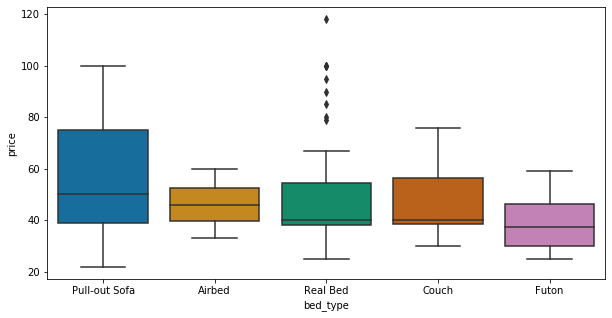

In [88]:
# price per night for room_type 'Shared Room'
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.boxplot(x= 'bed_type', y= 'price', data=listings_df.query("room_type == 'Shared room'"));

So we can see that with 95$ per night for a Pull-out Sofa we're clearly dealing with an ountlier that I feel comfortable to exclude from further analysis.

In [89]:
listings_df.drop(listings_df[listings_df.host_acceptance_rate == 0 ].index, inplace=True)

Now that we removed this row the host_acceptance_rate is 100 for all of our entries. Let's check if there are any other columns that only store one value. We'll remove these columns as they don't add any new information for our predictive model later on.

In [90]:
same_value_cols = []
for col in listings_df.columns:
    len_entries = len(listings_df[col].value_counts())
    if len_entries == 1:
        same_value_cols.append(col)
    else:
        pass
    
listings_df.drop(same_value_cols, axis=1, inplace=True)

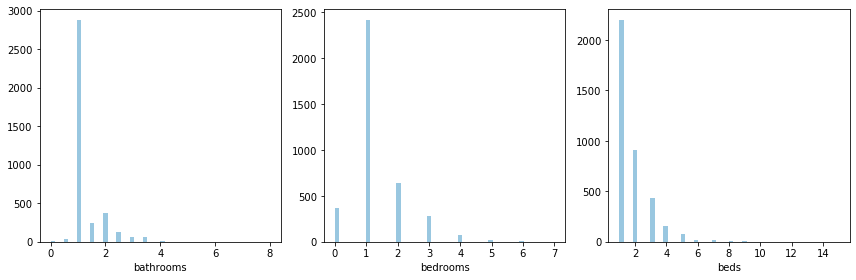

In [91]:
# distribution of values for bathroonms, bedrooms and beds
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
for (i, col) in enumerate(['bathrooms', 'bedrooms', 'beds']):
    sns.distplot(listings_df[col].dropna(), ax=axs[i], kde=False)
fig.tight_layout()

For these varianble we'll fill missing values with the most occuring values in the series - the mode.

In [603]:
# fill rows with no information for bathrooms, bedrooms or beds
for col in ['bathrooms', 'bedrooms', 'beds']:
    listings_df[col].fillna(listings_df[col].mode(), inplace=True)

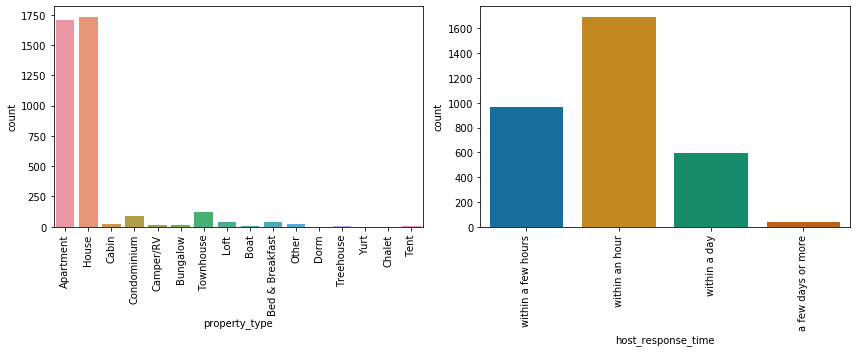

In [93]:
# counts of values for property_type and Host_response_time
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for (i, col) in enumerate(['property_type', 'host_response_time']):
    sns.countplot(listings_df[col].dropna(), ax=axs[i])
    axs[i].set_xticklabels(listings_df[col].dropna().unique(), rotation=90)
fig.tight_layout()

Again we will fill the missing values with the mode for these columns.

In [94]:
# fill rows with no information for 'property_type' and 'host_response_time'
for col in ['property_type', 'host_response_time']:
    listings_df[col].fillna(listings_df[col].mode()[0], inplace=True)

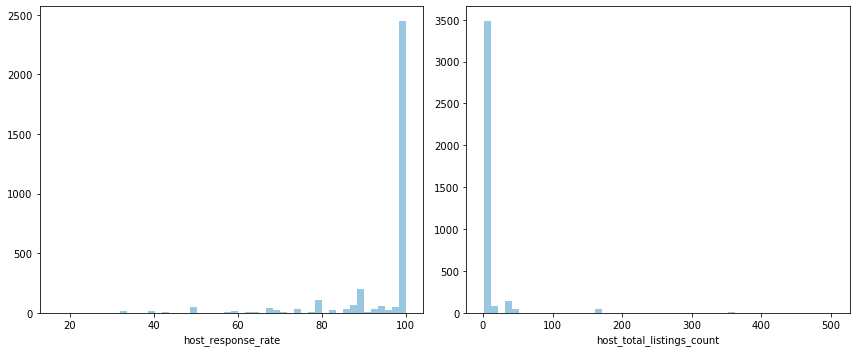

In [95]:
# counts of values for host_response_rate and host_total_listings_count
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for (i, col) in enumerate(['host_response_rate', 'host_total_listings_count']):
    sns.distplot(listings_df[col].dropna(), ax=axs[i], kde=False)
fig.tight_layout()

We work with the mode for 'host_response_rate' again and look up the missing values for the 'host_total_listings_count' by grouping the data by 'host_id' and fill with the number of entries for that id.

In [96]:
# fill rows with no information for 'host_response_rate'
listings_df.host_response_rate.fillna(listings_df.host_response_rate.mode(), inplace=True)

In [97]:
# fill missing total listings_count with number of entries for every host_id with a missing listings_count 
missing_total_listings = listings_df[listings_df.host_total_listings_count.isna()].host_id.values

for host_id in missing_total_listings:
    fill_value = len(listings_df[listings_df.host_id == host_id])
    listings_df.loc[listings_df.host_id == host_id, 'host_total_listings_count'] = fill_value

Now most of the left mising values are related to the review score columns. First we'll filter the data for entries that actually have reviews.

In [558]:
reviews_df = reviews_df[reviews_df.number_of_reviews !=0]
get_missing_values_ratio(reviews_df)

review_scores_checkin          0.009718
review_scores_accuracy         0.009718
review_scores_value            0.009091
review_scores_location         0.008777
review_scores_cleanliness      0.008150
review_scores_communication    0.007524
review_scores_rating           0.006270
dtype: float64

As it is important for our analysis to have a review score related to price we'll drop any row that has not an entry for that variable. It's hard  to fill these values with the mode or mean as listings, guests and perception can be so different.

In [ ]:
reviews_df.dropna(how='any', inplace=True)

## Exploring the data

For futher investigation on the review scores we will branch a separate DataFrame out of the listings because we will need to filter the DataFrame only to lisitngs that actually have reviews.

In [566]:
def get_city_nb_gdf(dataframe, cols):
    """GeoDataFrame of median and mad of column grouped by city and neighborhood."""
    # load city neighbourhood geodata
    
    nbhd_geodata = gpd.read_file('seattle/neighbourhoods.geojson').set_index(keys=['neighbourhood'])

    nbhd_geodata = nbhd_geodata.drop(columns=['neighbourhood_group'])
    nbhd_gdf = gpd.GeoDataFrame(nbhd_geodata, crs="EPSG:4326")
    
    # Define a lambda function to compute the weighted mean:
    wm = lambda x: np.average(x, weights=dataframe.loc[x.index, "number_of_reviews"])
    rpl = lambda x: np.sum

    # get median of columns grouped by neighborhood
    data = dataframe.groupby(['neighbourhood_cleansed'])
    df = pd.DataFrame(index=nbhd_gdf.index)
       
    # aggregate data per neighborhood
    df = df.join(
        data.agg(
            rating_weighted_mean=("review_scores_rating", wm),
            price_weighted_mean=("price", wm),
            listings_per_neighborhood=("id", "count"),
            total_reviews_per_neighborhood=("number_of_reviews", "sum")))
    df['RpL'] = df.total_reviews_per_neighborhood  / df.listings_per_neighborhood
        
    seattle_gdf = nbhd_gdf.merge(df, how='inner', 
                                    left_index=True, right_index=True)

    # # drop duplicates 
    seattle_gdf.drop_duplicates(inplace=True)
    seattle_gdf.dropna(subset=seattle_gdf.columns.drop('geometry'), how='any', inplace=True)
    # # drop duplicated entry for 'Industrial District'
    seattle_gdf.index.name = 'neighbourhood'
    seattle_gdf.reset_index(inplace=True)
    duplicate_index = seattle_gdf[seattle_gdf.neighbourhood.duplicated()].index
    seattle_gdf.drop(duplicate_index, axis=0, inplace=True)
    
    return seattle_gdf.set_index('neighbourhood')

We'll combine the Geodata for Seattle with statistics for each heighborhood to finally plot this information on a map. I decided to work with a weighted mean here because I feel it's mor accurate to weight listings with more reviews than just take the mode or mean. 
For the price this represents the mean accpted price people are willing to pay in that neighborhood. For the reviews this really is the weighted review score. 

In [568]:
seattle_gdf = get_city_nb_gdf(reviews_df, cols=['price', 'review_scores_rating'])
seattle_gdf

,geometry,rating_weighted_mean,price_weighted_mean,listings_per_neighborhood,total_reviews_per_neighborhood,RpL
neighbourhood,,,,,,
Adams,"MULTIPOLYGON (((-122.37634 47.67592, -122.3762...",95.688912,111.704312,57.0,1948.0,34.175439
Alki,"MULTIPOLYGON (((-122.38153 47.58950, -122.3818...",94.990909,135.449091,28.0,550.0,19.642857
Arbor Heights,"MULTIPOLYGON (((-122.37690 47.51749, -122.3760...",97.000000,157.043478,3.0,46.0,15.333333
Atlantic,"MULTIPOLYGON (((-122.31677 47.60172, -122.3123...",94.862661,101.282403,42.0,1165.0,27.738095
Belltown,"MULTIPOLYGON (((-122.35845 47.61861, -122.3578...",93.884123,140.993811,203.0,4686.0,23.083744
...,...,...,...,...,...,...
West Woodland,"MULTIPOLYGON (((-122.37634 47.67592, -122.3760...",95.622928,117.190608,54.0,2172.0,40.222222
Westlake,"MULTIPOLYGON (((-122.34354 47.62802, -122.3435...",95.037037,228.777778,10.0,81.0,8.100000
Whittier Heights,"MULTIPOLYGON (((-122.37634 47.67592, -122.3765...",97.274465,92.431193,24.0,1308.0,54.500000


In [469]:
def map_plot(df, cols, cmap=['Oranges', 'Blues'], title=['Median prices', 'Median overall ratings']):
    """Plot median prices and ratings on seattle neighbourhood map."""
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for (i, col) in enumerate(cols):
        df.plot(column=col, ax=axs[i], cmap=cmap[i], legend=True)
        axs[i].set_title(title[i])

In [573]:
def price_rating_plot(df):
    """Compare prices per neighbourhood with related median rating"""
    
    data = df.sort_values('price_weighted_mean', ascending=True)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

    sns.barplot(x=data.index, y='price_weighted_mean', data=data, ax=ax1, palette='Blues')
    ax1.axhline(0, color="k", clip_on=False)
    ax1.set_ylabel("weighted accepted price")

    sns.scatterplot(x=data.index, y='rating_weighted_mean', data=data, ax=ax2)
    ax2.set_ylabel("weigghted overall rating")
    ax2.set_xticklabels(data.index, rotation=90)

In [569]:
# reduce dataframe to observations with more than 10 reviews per listing on average
seattle_gdf_filtered = seattle_gdf.query('RpL > 10')

In [570]:
seattle_gdf_filtered

,geometry,rating_weighted_mean,price_weighted_mean,listings_per_neighborhood,total_reviews_per_neighborhood,RpL
neighbourhood,,,,,,
Adams,"MULTIPOLYGON (((-122.37634 47.67592, -122.3762...",95.688912,111.704312,57.0,1948.0,34.175439
Alki,"MULTIPOLYGON (((-122.38153 47.58950, -122.3818...",94.990909,135.449091,28.0,550.0,19.642857
Arbor Heights,"MULTIPOLYGON (((-122.37690 47.51749, -122.3760...",97.000000,157.043478,3.0,46.0,15.333333
Atlantic,"MULTIPOLYGON (((-122.31677 47.60172, -122.3123...",94.862661,101.282403,42.0,1165.0,27.738095
Belltown,"MULTIPOLYGON (((-122.35845 47.61861, -122.3578...",93.884123,140.993811,203.0,4686.0,23.083744
...,...,...,...,...,...,...
Wedgwood,"MULTIPOLYGON (((-122.30546 47.69756, -122.3045...",93.209790,72.185315,13.0,286.0,22.000000
West Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569...",95.748990,130.950000,55.0,1980.0,36.000000
West Woodland,"MULTIPOLYGON (((-122.37634 47.67592, -122.3760...",95.622928,117.190608,54.0,2172.0,40.222222


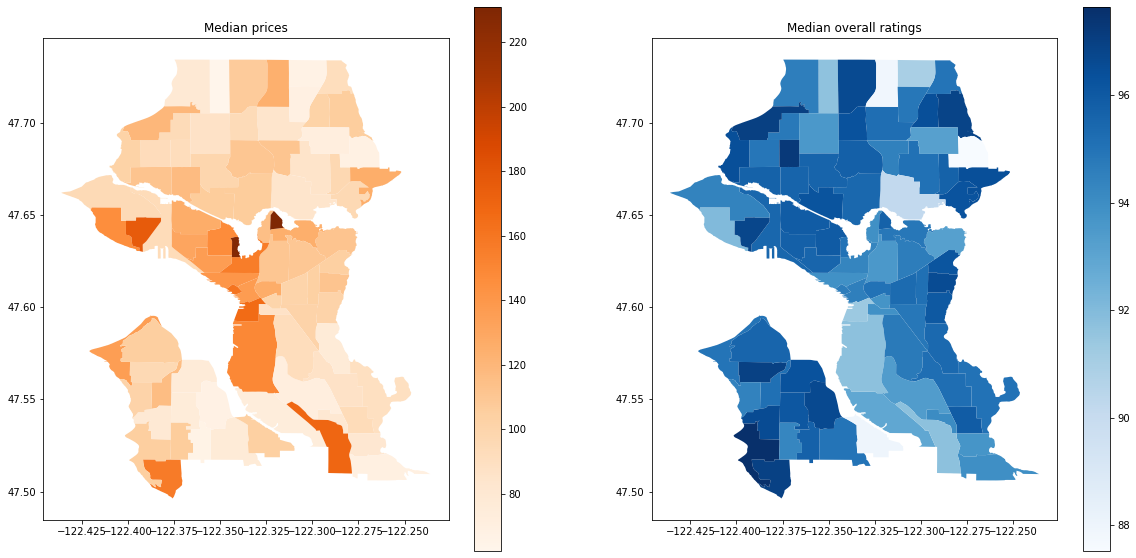

In [571]:
map_plot(seattle_gdf, ['price_weighted_mean', 'rating_weighted_mean'])

Areas with higher weighted listing prices are located in and around the downtown district. This is to be expected due to higher housing prices in that area.
In some areas with the highest prices, aswell as areas with the lowest prices the overall satisfaction is fairly low.

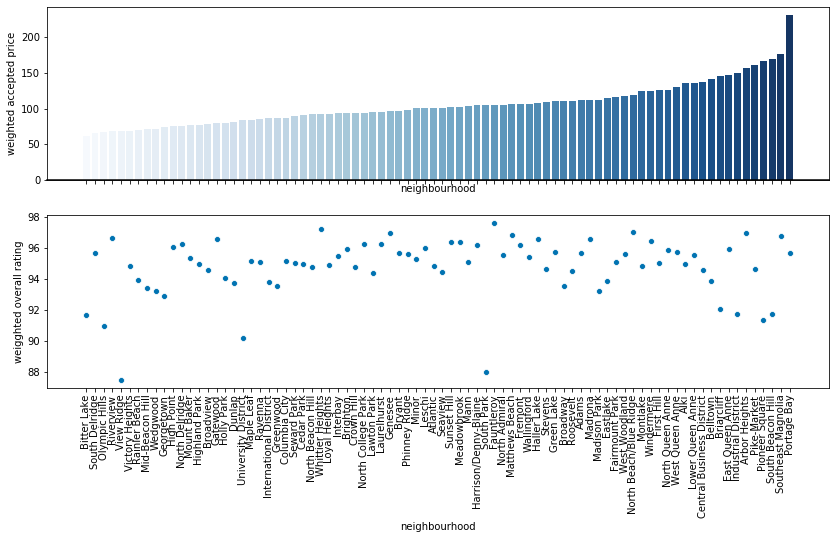

In [574]:
price_rating_plot(seattle_gdf_filtered)

The left of the charts represents neighborhoods with the lowest price points and the right, neighborhoods with the highest. Generally, these neighborhoods have lower overall satisfaction ratings. This could be because of expectations may differ with the extraordinary high or low price.

In [593]:
def categorize_price(price):
        """
        INPUT: price - string with price information
        OUTPUT: price_cat - price category as string
        """
        if price < 75:
            return 'low'
        elif price > 140:
            return 'high'
        else:
            return 'moderate'

price_cat_df = seattle_gdf_filtered.copy()
price_cat_df['price_cat'] = price_cat_df.price_weighted_mean.map(lambda price: categorize_price(price))

price_cat_df.groupby('price_cat')['rating_weighted_mean'].mean()

price_cat
high        94.087759
low         93.090716
moderate    95.216857
Name: rating_weighted_mean, dtype: float64

According to the price categorization above, the average guest satisfaction ratings will be lower for listings with prices on the upper or lower end of the range.

## Predicting model

In [264]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3157 entries, 0 to 3814
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3157 non-null   int64  
 1   host_id                           3157 non-null   int64  
 2   host_since                        3157 non-null   object 
 3   host_response_time                3157 non-null   object 
 4   host_response_rate                3157 non-null   float64
 5   host_is_superhost                 3157 non-null   bool   
 6   host_total_listings_count         3157 non-null   float64
 7   host_has_profile_pic              3157 non-null   bool   
 8   host_identity_verified            3157 non-null   bool   
 9   neighbourhood_cleansed            3157 non-null   object 
 10  latitude                          3157 non-null   float64
 11  longitude                         3157 non-null   float64
 12  proper

In [606]:
def get_dummies(df):
    """Creates dummy variables for all columns except 'amenities'"""
    # columns to create dummy variables. ameniites column will get a special treatment
    dummy_columns = df.select_dtypes('object').columns.drop('amenities')
    df = pd.get_dummies(data=df, columns=dummy_columns)
    df = create_amenities_dummies(df)
    
    return df

In [266]:
def create_amenities_dummies(dataframe):
    """Unpacks list of amenities and cleans categories to finally create dummies from the data."""
    translation_table = dict.fromkeys(map(ord, '{"}'), None)
    
    amenities_lists = dataframe.amenities.apply(lambda raw_string: raw_string.translate(translation_table).split(','))
    amns_df = pd.get_dummies(amenities_lists.apply(pd.Series).stack(), drop_first=True).sum(level=0)

    # remove 'Washer / Dryer' column because of additonal noise for model
    amns_df.drop('Washer / Dryer', axis=1, inplace=True)
    # assign 'Internet' = True where 'Wireless Internet' is available
    amns_df.Internet = np.where(amns_df['Wireless Internet'] == 1, 1, amns_df.Internet)

    # assign 'Pets Allowed' =1 to all rows with cats/dogs/other pets == 1 and drop these rows
    amns_df['Pets Allowed'] = np.where((amns_df['Cat(s)']==1) | (amns_df['Dog(s)']==1) | (amns_df['Other pet(s)']==1), 1, amns_df['Pets Allowed'])
    # remove now obsolete columns
    amns_df.drop(['Cat(s)', 'Dog(s)', 'Other pet(s)'], axis=1, inplace=True)
    dataframe.drop('amenities', axis=1, inplace=True)
        
    return dataframe.join(amns_df)

For our feature Dataframe we get rid of some more variables that are likely to add more noise to the regression.

In [297]:
more_cols_to_drop = ['id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_total_listings_count',
       'latitude', 'longitude', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month']
    
price_model_df = reviews_df.drop(more_cols_to_drop, axis=1)
feature_df = get_dummies(price_model_df)

In [607]:
def predict_values(feature_df, response_var):
    """Split data into test and train data, fits the model and predicts the respoonse variable."""

    #Split into explanatory and response variables
    X = feature_df.drop(response_var, axis=1)
    y = feature_df[response_var]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .40, random_state=27) 

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

     #Predict the response for the training data and the test data
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    root_mse_train = mean_squared_error(y_train_preds, y_train)**(1/2)
    r2_train = r2_score(y_train, y_train_preds)
    
    root_mse_test = mean_squared_error(y_test_preds, y_test)**(1/2)
    r2_test = r2_score(y_test, y_test_preds)

    #Obtain an rsquared value for both the training and test data
    print('test_score: {}, root mse: {}'.format(r2_test, root_mse_test))
    print('train_score: {}, root mse: {}'. format(r2_train, root_mse_train))

In [356]:
predict_values(feature_df, 'price')

test_score: -2.4208232951536427e+24, root mse: 155291786518273.88
train_score: 0.642029112369265, root mse: 49.606436159337974


The training score isn't really that good and we cannot work with the test score at all. We have to improve our model by preparing the input data in a better way.

In [608]:
def plot_quant_vars(df, num_rows, num_cols):
    """Distribution plots for quantitative variables"""
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,20))
    axs = axs.flatten()
    for (i, col) in enumerate(df.columns):
        sns.distplot(df[col], kde=False, norm_hist=True, ax=axs[i])
    fig.tight_layout()

In [609]:
def plot_cat_vars(df, num_rows, num_cols):
    """Distribution plots for categorical variables"""
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,15))
    axs = axs.flatten()
    for (i, col) in enumerate(df.columns):
        sns.countplot(df[col], ax=axs[i])
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    fig.tight_layout()

In [272]:
quant_df = reviews_df.select_dtypes(['int64', 'float64'])
bool_df = reviews_df.select_dtypes(['bool'])
object_df = reviews_df.select_dtypes(['object']).drop(
    ['host_since', 'amenities', 'calendar_updated', 
     'first_review', 'last_review'], axis=1)

print(len(quant_df.columns))
print(len(bool_df.columns))
print(len(object_df.columns))

30
6
6


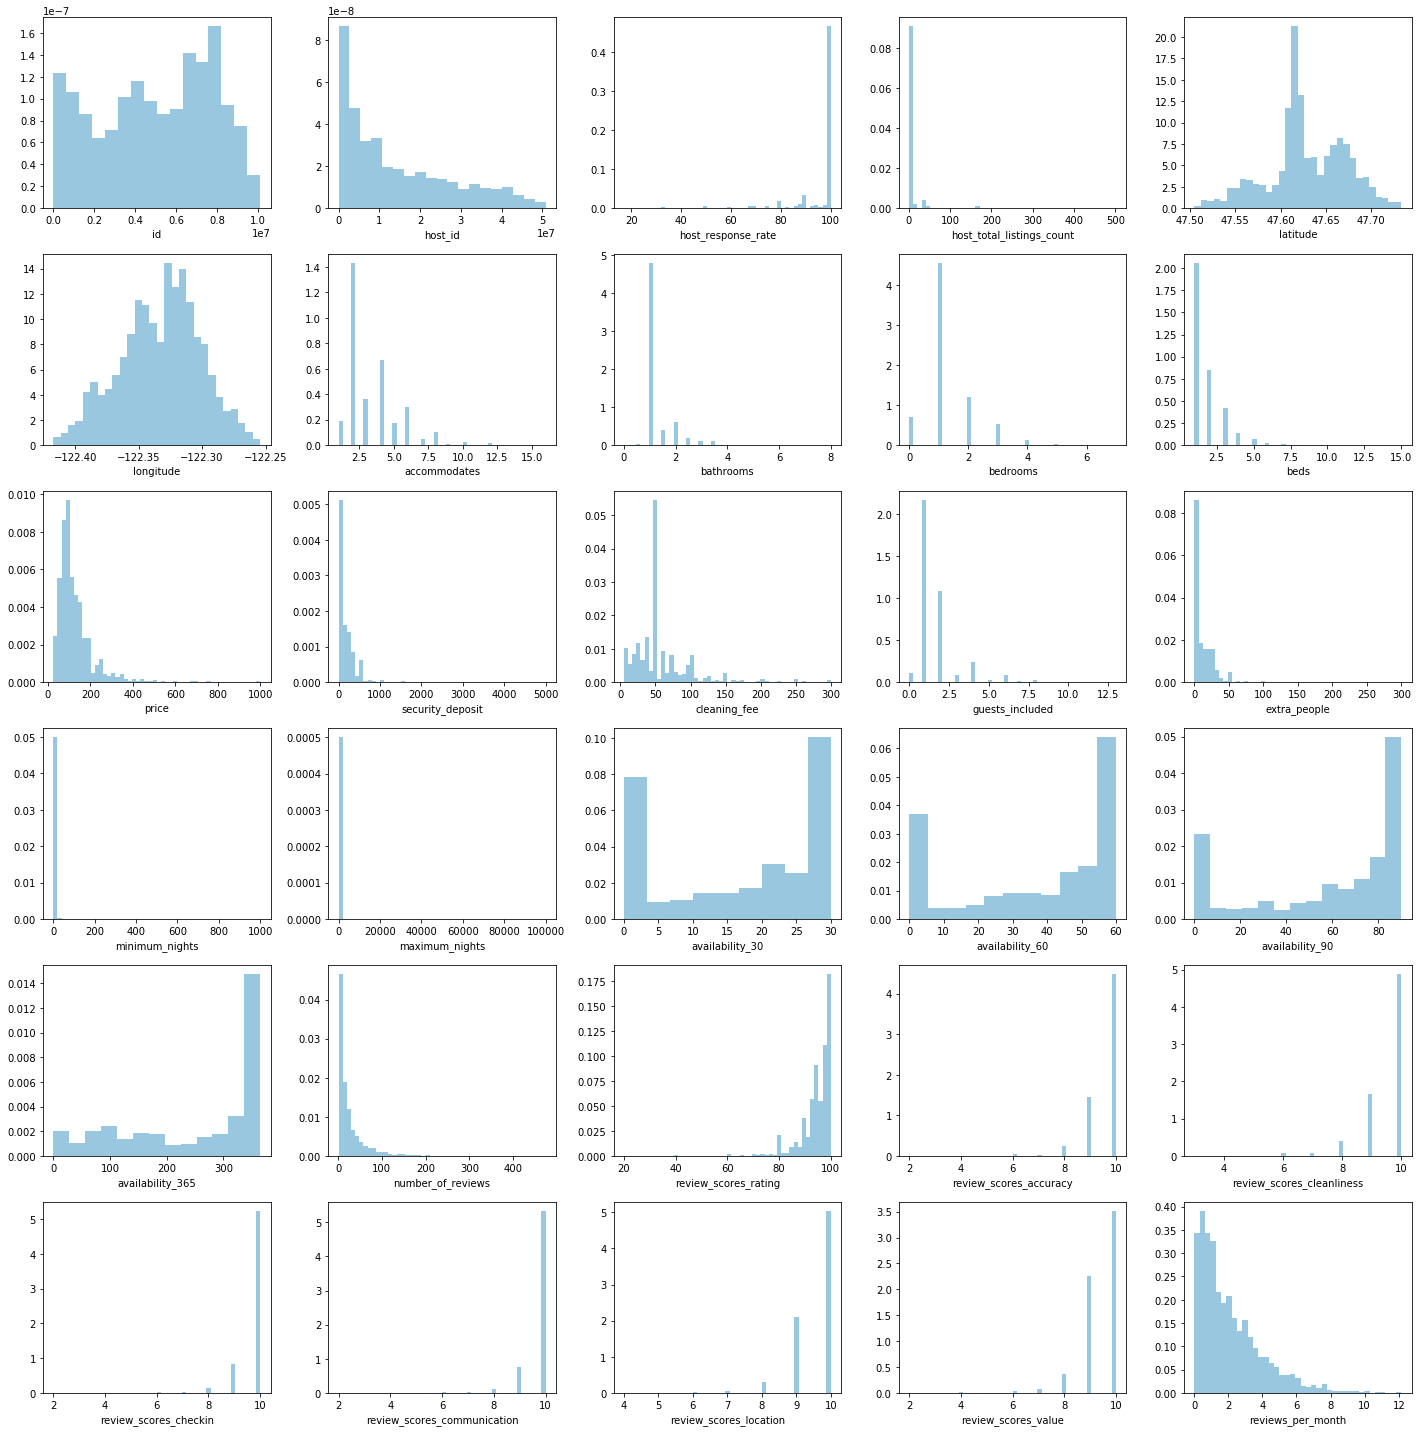

In [273]:
plot_quant_vars(quant_df, 6,5)

Most of the variables are not normal distributed but heavily skewed. Variable transformations should help  here.

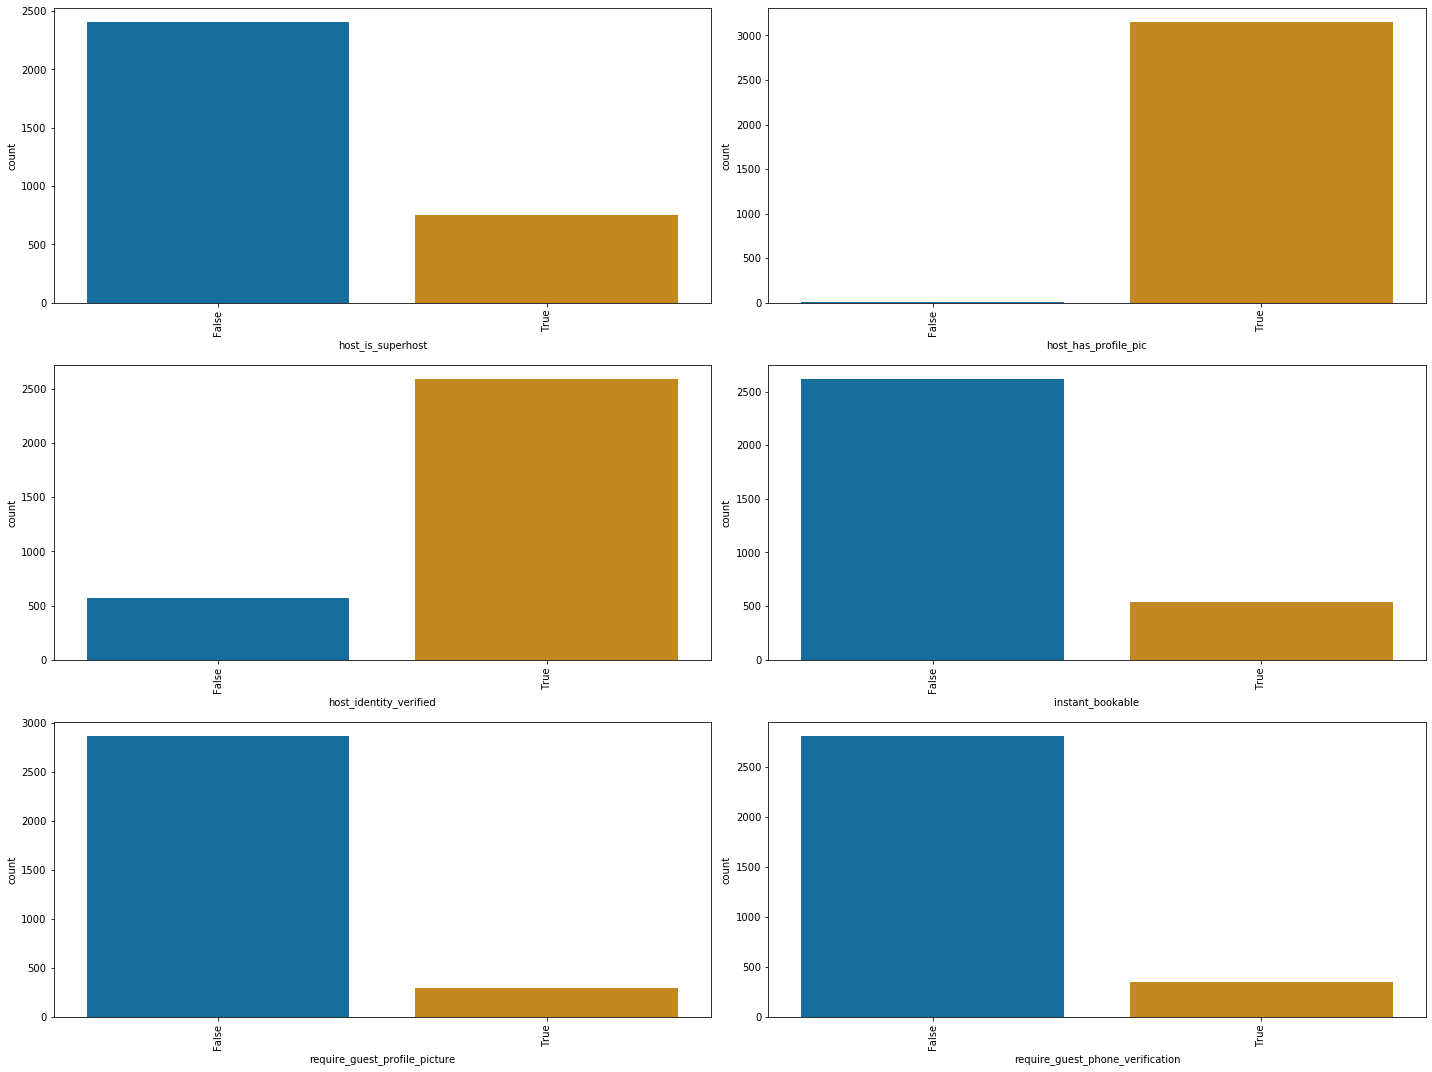

In [274]:
plot_cat_vars(bool_df, 3,2)

The variable 'host_has_profile_pic' is heavily biased. Eventually we'll get rid of the variable.

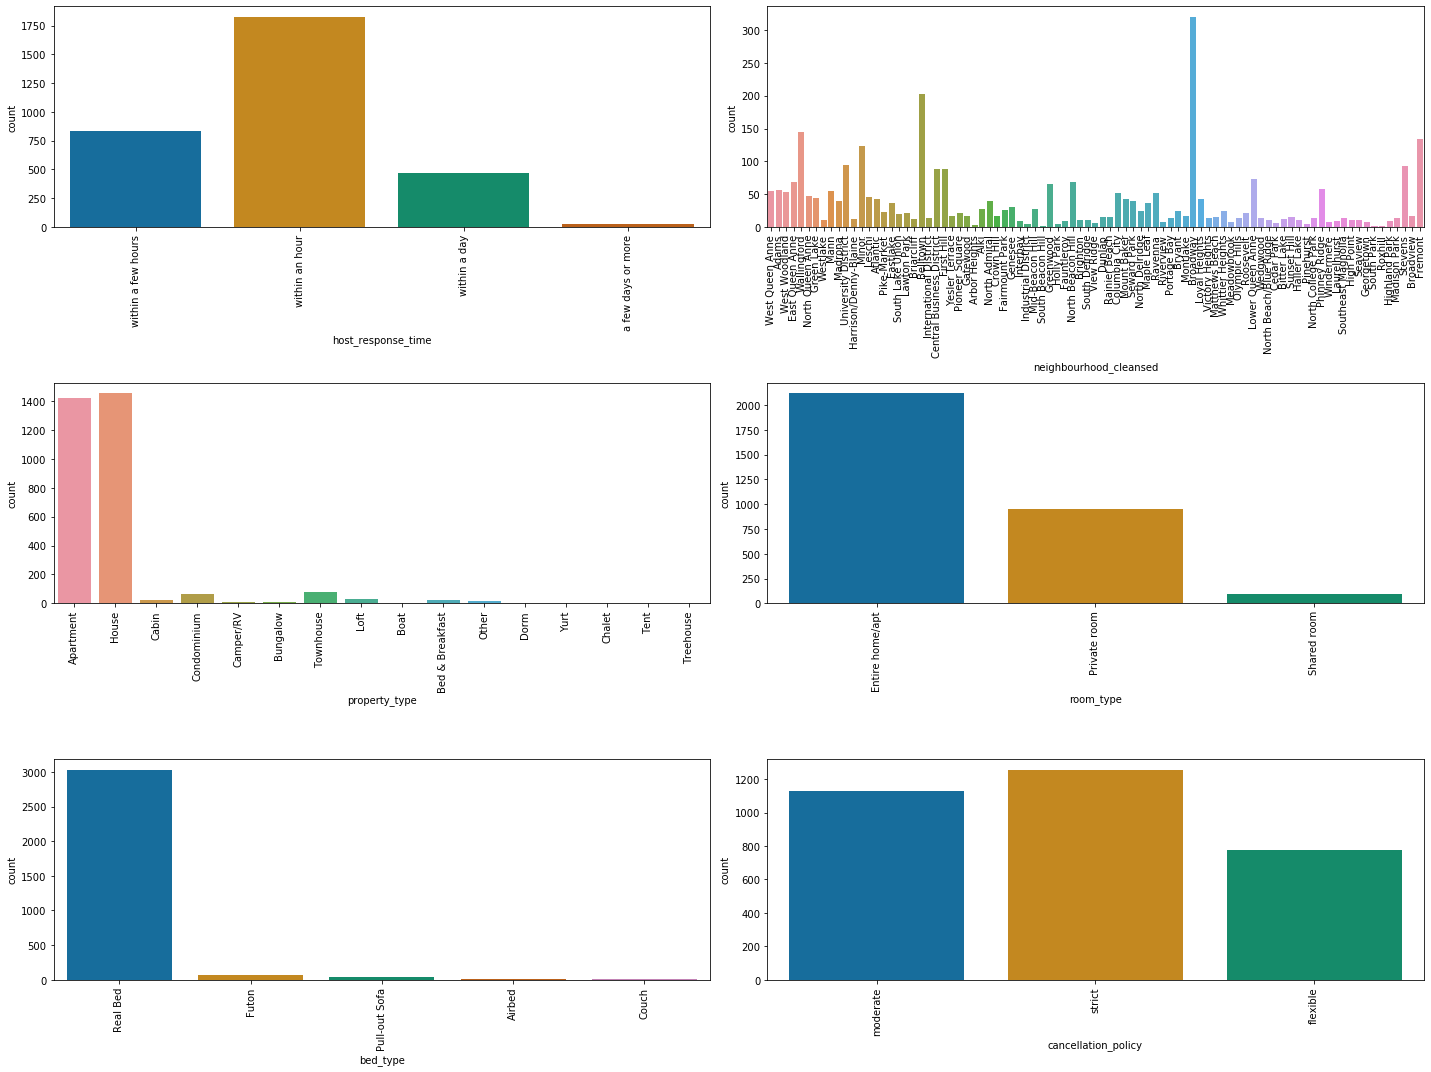

In [275]:
plot_cat_vars(object_df, 3,2)

The majoriy of listings is an house or apartment with a real bed. We'll narrrow down the input data to these categories.

In [309]:
def reduce_inputs(df):

    df= df.loc[
        df.property_type.isin(['Apartment', 'House']) &
        df.bed_type.isin(['Real Bed']) &
        df.room_type.isin(['Entire home/apt', 'Private room']) &
        df.host_has_profile_pic == True
    ]
    
    df = df.drop('host_has_profile_pic', axis=1)
    for col in price_columns:
        df[col] = df[col].apply(lambda col: np.log(col + 1))
    df = get_dummies(df)
    
    return df

In [611]:
filtered_input = reduce_inputs(price_model_df)

In [612]:
predict_values(filtered_input, 'price')

test_score: -6.240957985347558e+23, root mse: 419835323112.11414
train_score: 0.741412433051412, root mse: 0.2715544534007051


We now achieve a better train score but we still cannot work with the prediction. There is some more work required.